In [1]:
# !pip3 install -q -r requirements.txt

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

import gymnasium as gym
import numpy as np
import time

from collections import deque

from IPython import display
import imageio
import os
FP = './animations'
# !pipreqsnb --force

In [2]:
ENV = gym.make("Taxi-v3", render_mode="rgb_array")
N_STATES = ENV.observation_space.n # 25 taxi positions * 5 passenger locations * 4 destinations
N_ACTIONS = ENV.action_space.n
ACTIONS_STR = ('^','v','<','>','p','d') # for taxi policy visualization

In [3]:
def rr(env=ENV, capture=False):
    """quick render fix assuming env's render_mode='rgb_array' """
    arr = env.render()
    if capture:
        return arr
    else:
        plt.axis('off')
        plt.imshow(arr)
               
def act(action, env=ENV):
    """filters unnecessary output"""
    return env.step(action)[:3]

In [4]:
# auxillary functions
def lin_ann_rate(i, n_total, start=1):
    return start * (1 - i / (n_total - 1))

def exp_ann_rate(i, start=1, thr=0, la=2/300, drop=0):
    """exponential decay with i --> +inf, provides descending values within range [expl_thr, start],
        la=0.01 means ~36% left after 100 iterations, results < drop value are zeroed"""
    result = thr + (start - thr) * np.exp(- la * i)
    if drop:
        if isinstance(i, np.ndarray):
            result[result <= drop] = 0
        elif result < drop:
            result = 0 
    return result

def sgm_ann_rate(i, mid, start=1, alpha=1e-2, drop=0):
    """symmetic sigmoidal decay within [0, 2*mid-1] provides descending values within range [1-alpha, alpha], results < drop value are zeroed,
        alpha controls the gap between function value and its asymptotes (i=1/i=0)"""
    # establish max possible smoothness given alpha and symmetrize wrt mid value (this form has been pre-simplified and doesn't depend on exp or log realisation)
    result = start * (1 + (1/alpha - 1) ** ((i - mid)/mid) )**(-1)
    if drop:
        if isinstance(i, np.ndarray):
            result[result <= drop] = 0
        elif result < drop:
            result = 0 
    return result

def anneal_comparison(n=500):
    i = np.arange(n)
    ax = sns.lineplot(lin_ann_rate(i, n), linewidth=1.2, label=f"base")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_title(f"Annealing rates comparison", fontsize=15)
    ax.set_xlabel('iterations - 1')
    [sns.lineplot(sgm_ann_rate(i, n/2, alpha=j, drop=0), linewidth=1, ax=ax, label=f"α={j:.3f}") for j in np.arange(1e-5, 1e-1, 2e-2)]
    [sns.lineplot(exp_ann_rate(i, thr=0, la=j/n, drop=0), linewidth=1, ax=ax, label=f"λ={j/100}") for j in np.arange(2, 100, 20)]

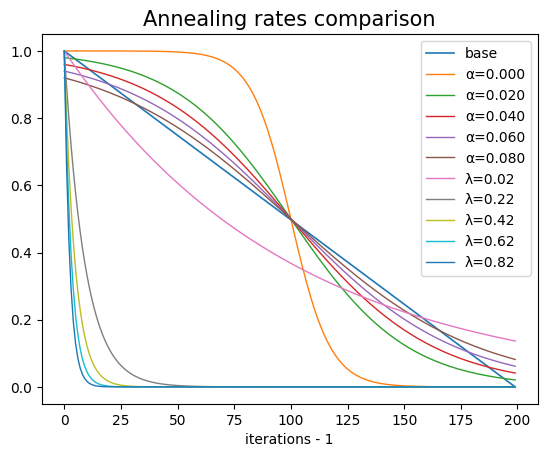

In [5]:
anneal_comparison(200)

In [6]:
class RandAgent():
    """baseline agent that performs random (sample from uniform distr) actions"""
    def __init__(self, n_states=N_STATES, n_actions=N_ACTIONS, aid_to_str=ACTIONS_STR, capture_path=FP):
        self.n_states = n_states
        self.n_actions = n_actions
        self.aid_to_str = aid_to_str # action symbols (to be shown on policy graph)
        self.log = [] # container for anything related to learning process (to be shown on a graph)
        self.rendered_frames = None # container for rendered images (numpy arrays) used by '.capture' method
        self.capture_path = capture_path
        self.fly = None # some method to be executed throughout a trajectory (e.g. change policy based on local MDP context)
        self.policy = np.ones((self.n_states, self.n_actions))/self.n_actions # uniform policy initialisation (sa)
        
    def act(self, state):
        """draws a random sample from current distribution on actions"""
        action = np.random.choice(self.n_actions, p=self.policy[state]) # outputs integers thus doesn't require .item()
        return action

    def walk(self, max_length, render=False, **interkwargs):
        """perform max_length actions by agent N"""
        states, actions, rewards = [], [], []
        state = ENV.reset()[0] # initial state
        q6 = deque(maxlen=6) # prepare a fixed-size queue as 2-step MDP (sarsar) storage
        for i in range(max_length):
            # perform an action
            action = self.act(state)
            new_state, reward, done = act(action)
            # log 
            states.append(state) # append OLD state, everything breaks if you start from new
            actions.append(action)
            rewards.append(reward)
            # add (append) current step (sar) to queue
            q6.extend((state, action, reward))
            state = new_state
            if interkwargs and self.fly:
                try:
                    self.fly(q6, **interkwargs)
                except AttributeError:
                    print("intermediary update method hasn't been defined for this class")
            # continuous visualization w/ proper interrupt
            if render:
                try:
                    if render == 2:
                        arr = rr(capture=True)
                        self.rendered_frames.append(arr)
                    else:
                        rr()
                        display.display(plt.gcf())
                        time.sleep(1e-4)
                        display.clear_output(wait=True)
                except KeyboardInterrupt:
                    break
            if done:
                break
        trajectory = {'s': states,
                        'a': actions,
                            'r': rewards,}
        return trajectory
        
    ### VISUALIZATION ###    
    def capture(self, max_length, fps=30, fpath=FP):
        """captures render output and creates gif animation from frames (rgb arrays)"""
        self.rendered_frames = []
        results = self.walk(max_length, render=2)
        name = ENV.unwrapped.spec.id + '.gif'
        path = os.path.join(fpath, name)
        imageio.mimsave(path, ims=self.rendered_frames, fps=fps)
        print(f"Trajectory with reward {sum(results['r'])} has been captured to {path}")

    def learning_curve(self, title="", label="", logscale=False, show_max=True, ax=None):
        """plots log vs iterations of algorithm"""
        ax = sns.lineplot(self.log, linewidth=1.0, ax=ax, label=label)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_title(title, fontsize = 10)
        ax.set_xlabel('iterations - 1')
        if logscale:
            ax.set_yscale('symlog')
        if show_max:
            ax.axhline(y=max(self.log), color='r', linestyle='-', linewidth=0.5)
        return ax

    def show_policy(self, label=None):
        """plots current policy matrix as a heatmap"""
        plt.figure(figsize=(2, 5))
        concise_actions = {'xticklabels': self.aid_to_str} if self.aid_to_str else {}
        ax = sns.heatmap(self.policy, **concise_actions, cbar=False)
        ax.set_title(label if label else 'Current policy')
        return ax
        
class CrossEntropyAgent(RandAgent):
    """CrossEntropy algorithm actor, optimizes expected reward by policy"""
    def __init__(self):
        super().__init__()
        
    def fit(self, n_iterations, n_trajectories=700, max_length=950, q=0.7, la=None, lr=0.95, verbose=None):
        """
        CE Algorithm has 2 steps per iteration: evaluate policy, improve policy
        Our goal is to maximize expected reward ER which is unreachable => approximated
        
        n_trajectories (length <= max_length) defines quality of ER approximation
        0<q<1 controls rejected quantile of trajectories
        
        la>0 controls (and enables) Laplace policy smoothing
        lr>0 controls (and enables) exponential policy smoothing (interpreted as learning rate)

        verbose>0 sets up a period of learning process rendering
        """

        for i in range(n_iterations):
            # policy evaluation (act with current policy)
            trajectories = [self.walk(max_length=max_length) for t in range(n_trajectories)]
            rewards = np.stack([np.sum(t['r']) for t in trajectories])
            avg_reward = np.mean(rewards)
            self.log.append(avg_reward)
            # policy improvement
            gamma = np.quantile(rewards, q) # get q-quantile of current reward distribution and filter out better trajectories
            elite_ids = (rewards > gamma).nonzero()[0]
            # redistribute actions at each state according to these results (put higher weights)
            if elite_ids.any():
                dummy = np.zeros_like(self.policy)
                for ei in elite_ids:
                    et = trajectories[ei]
                    # count number of occurrences for all pairs s-a, all trajectories
                    dummy[et['s'], et['a']] += 1
                occurrences_of_states = dummy.sum(axis=1, keepdims=True)
                occurrences_of_states[occurrences_of_states==0] = 1E-2 # prevent zero division error AND populate with sth>0 in case dummy's row has all zeros
                # involves broadcasting, la or lr turn on smoothing if provided
                new_policy = (dummy + la)/(occurrences_of_states + la*self.n_actions) if la else dummy/occurrences_of_states
                policy_ = lr * new_policy + (1 - lr) * self.policy if lr else new_policy + self.policy
                # normalize (make new rows sum up to 1)
                self.policy = policy_/policy_.sum(axis=1, keepdims=True)
                
            # visualization
            if verbose and i > 0 and (i + 1) % verbose == 0:
                plt.close() # because plt.clf() is spurious
                ax = self.learning_curve(title=f"Mean rewards over {n_trajectories} trajectories of length < {max_length}", label=f'lr={lr}', logscale=True)
                # self.show_policy(label=f"Agent's policy after {i+1} iterations")
                display.display(plt.gcf())
                display.clear_output(wait=True)
        return avg_reward

class ModelFreeAgent(RandAgent):
    """Model-free agent == R, TP functions of ENV aren't provided and aren't (explicitly?) approximated"""
    def __init__(self):
        super().__init__()

    def gpi(self, q, eps, zero_mask=None):
        """epsilon-greedy policy improvement based on values of q(s,a), at each state,
        policy ~ not only take an action that maximizes given action-value function q, 
        but also allow "the rest' actions happen with eps probability (shared)
        
        unvisited states have q=0 but that doesn't matter anything, 
        as rewards are < 0, such states would impact argmax,
        zero_mask removes them from computation"""
        if zero_mask is not None:
            q = np.ma.array(q, mask=zero_mask) 
        # epsilon-greedy: let eps be ~"the rest' actions probability, split it between the all actions
        dummy = (1 - eps + eps / self.n_actions) * np.eye(self.n_actions) + (eps / self.n_actions) * (np.ones(self.n_actions) - np.eye(self.n_actions))
        best_actions = np.argmax(q, axis=0) # 1D array of 'best' actions
        # one-hot encoding of best_actions array (used to choose rows from dummy)
        self.policy = dummy[best_actions]

    def fit(self, n_trajectories, max_length, alpha_s=0.5, gamma=0.99, verbose=False):
        dh = display.display(display_id=True)
        eps_rates, alpha_rates = [], []
        for i, t in enumerate(range(n_trajectories)):
            # decrease eps throughout the loop
            # eps = lin_ann_rate(i, n_trajectories, start=1)
            eps = exp_ann_rate(i, la=0.02, start=1, drop=1e-10)
            # decrease alpha ~ learning rate
            alpha = lin_ann_rate(i, n_trajectories, start=alpha_s)
            # policy evaluation and improvement throughout trajectory
            results = self.walk(max_length=max_length, alpha=alpha, eps=eps, gamma=gamma)
            # visualization
            eps_rates.append(eps)
            alpha_rates.append(alpha)
            self.log.append(sum(results['r']))
            # self.log.append(np.sum(self.q))
            if verbose:
                # ax = self.show_policy()
                ax = self.learning_curve(title=f"Total reward at trajectory of length < {max_length}", logscale=True)
                ax2 = ax.twinx()
                ax2.tick_params(axis='y', labelcolor='blueviolet')
                ax2 = sns.lineplot(eps_rates, linewidth=0.5, ax=ax2, label="exploration, ε‎", color='blueviolet')
                sns.lineplot(alpha_rates, linewidth=0.5, ax=ax2, label="learning rate, α", color='orchid')
                dh.update(plt.gcf())
                plt.close() # because plt.clf() is spurious

6.324285714285714

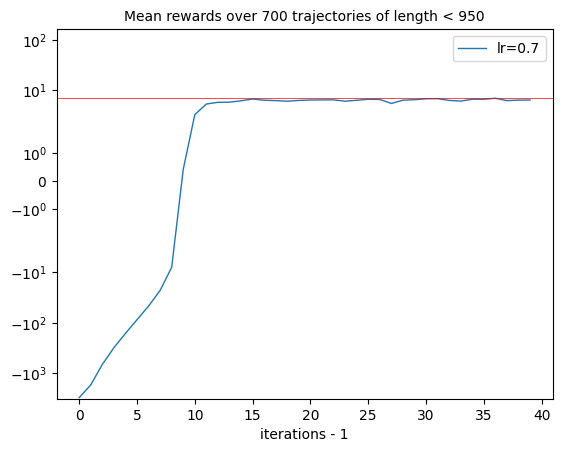

In [997]:
cea = CrossEntropyAgent()
cea.fit(n_iterations=40, verbose=1, lr=0.7)

In [7]:
class SARSAAgent(ModelFreeAgent):
    """SARSA updates at each step of every trajectory"""
    def __init__(self):
        super().__init__()
        self.Q = np.zeros_like(self.policy.T)
        self.fly = self.sarsa_step

    def sarsa_step(self, queue_6, alpha, eps, gamma):
        """accepts a queue object, updates value-function q and policy in sarsa manner"""
        if len(queue_6) == 6: # sarsar
            s, a, r, sx, ax = list(queue_6)[:5]
            self.Q[a, s] += alpha * (r + gamma * self.Q[ax, sx] - self.Q[a, s])
            self.gpi(self.Q, eps)

class QLearningAgent(ModelFreeAgent):
    """Q updates at each step of every trajectory"""
    def __init__(self):
        super().__init__()
        self.Q = np.zeros_like(self.policy.T)
        self.fly = self.ql_step

    def ql_step(self, queue_6, alpha, eps, gamma):
        """accepts a queue object, updates value-function q and policy ~ Q-learning"""
        if len(queue_6) == 6: # sarsar
            s, a, r, sx = list(queue_6)[:4]
            self.Q[a, s] += alpha * (r + gamma * np.max(self.Q[:, sx]) - self.Q[a, s])
            self.gpi(self.Q, eps)

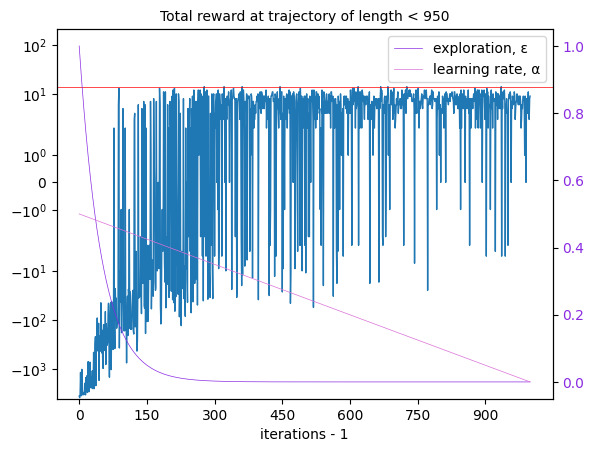

In [1004]:
sarsa = SARSAAgent()
sarsa.fit(n_trajectories=1000, max_length=950, alpha_s=0.5, gamma=0.999, verbose=True)

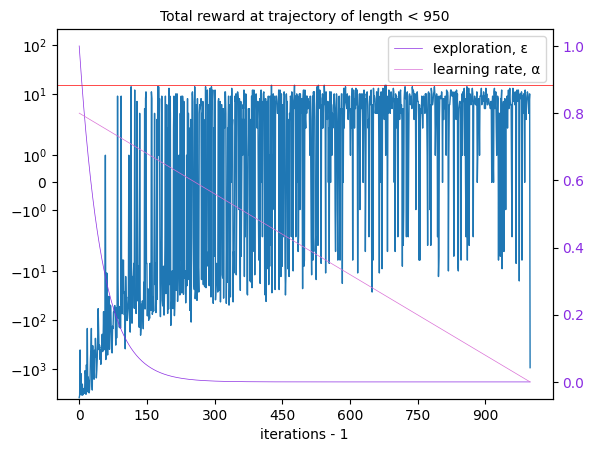

In [1005]:
qlr = QLearningAgent()
qlr.fit(n_trajectories=1000, max_length=950, alpha_s=0.8, gamma=0.9, verbose=True)

In [8]:
class MonteCarloAgent(ModelFreeAgent):
    """Applies Monte-Carlo sampling of trajectories for action-value function q approximation"""
    def __init__(self):
        super().__init__()

    # def walk_gn_test(self, gamma, max_length):
    #     """transforms standard results after tracing a route"""
    #     Q = np.zeros_like(self.policy.T)
    #     N = np.zeros_like(self.policy.T)
    #     trajectory = super().walk(max_length=max_length)
    #     R, A, S = trajectory['r'], trajectory['a'], trajectory['s']
    #     # get summands of rewards serie (w/ discounting)
    #     gamma_ = np.cumprod(np.concatenate((np.atleast_1d(1.), np.tile(np.array(gamma), len(R) - 1))))
    #     R_discounted = gamma_ * np.array(R)
    #     # get values of G as if we'd started at timestep t (aka returns)
    #     G = np.array([np.sum(R_discounted[t:]) / gamma**t for t in range(len(R_discounted))])
    #     for t, (r, a, s) in enumerate(zip(R,A,S)):
    #         Q[a, s] += (G[t] - Q[a, s])/(N[a,s] + 1)
    #         N[a, s] += 1
    #     return Q*N, N, sum(R)

    
    def walk_r(self, gamma, max_length):
        """transforms standard results after tracing a route, yields
            n (matrix a,s of visited state counts), 
            g (matrix a,s of returns)"""
        g, n = np.zeros_like(self.policy.T), np.zeros_like(self.policy.T)
        trajectory = super().walk(max_length=max_length)
        R, A, S = trajectory['r'], trajectory['a'], trajectory['s']
        # get rewards serie (summands, w/ discounting)
        gamma_ = np.cumprod(np.concatenate((np.atleast_1d(1.), np.tile(np.array(gamma), len(R) - 1))))
        R_discounted = gamma_ * np.array(R)
        # get values of returns G, e.g. total reward as if we'd started at timestep t and continued MDP on this trajectory
        G = np.array([np.sum(R_discounted[t:]) / gamma**t for t in range(len(R_discounted))])
        # get unique pairs from 2D array, their places and counts
        unp, pos, cts = np.unique(np.vstack([A, S]), axis=1, return_inverse=True, return_counts=True)
        # row vector of stacked Gt values @ matrix with (stacked as rows ~ pos) one-hot encoded unique states => row vector with sum of Gts at unique states
        g[*unp], n[*unp] = G @ (np.eye(len(cts))[pos]), cts
        return g, n, sum(R)

    def fit(self, n_trajectories, max_length, gamma=1, verbose=False):
        """MC approach replaces expected value calculation with an empirical mean of return Gt"""
        dh = display.display(display_id=True)
        eps_rates = []
        G, N = np.zeros_like(self.policy.T), np.zeros_like(self.policy.T)
        for i, t in enumerate(range(n_trajectories)):
            # MC policy evaluation to approximate Q
            g, n, r = self.walk_r(max_length=max_length, gamma=gamma)
            G, N = G + g, N + n
            Q = G / (N_ := N.copy() + 1E-2 * (N == 0)) # prevent zero-division error
            
            # decrease eps throughout the loop
            # eps = lin_ann_rate(i, n_trajectories, start=1)
            # eps = exp_ann_rate(i, la=0.02, start=1)
            eps = sgm_ann_rate(i, n_trajectories/2, alpha=0.1, drop=1E-7)
            
            # policy improvement with masked non-visited sa pairs
            self.gpi(Q, eps=eps, zero_mask=N==0)

            # visualization
            self.log.append(r)
            eps_rates.append(eps)
            if verbose:
                # ax = self.show_policy()
                ax = self.learning_curve(title=f"Total reward at trajectory of length < {max_length}", logscale=True)
                ax2 = ax.twinx()
                ax2.tick_params(axis='y', labelcolor='blueviolet')
                sns.lineplot(eps_rates, linewidth=0.5, ax=ax2, label="exploration, ε", color='blueviolet')
                dh.update(plt.gcf())
                plt.close() # because plt.clf() is spurious

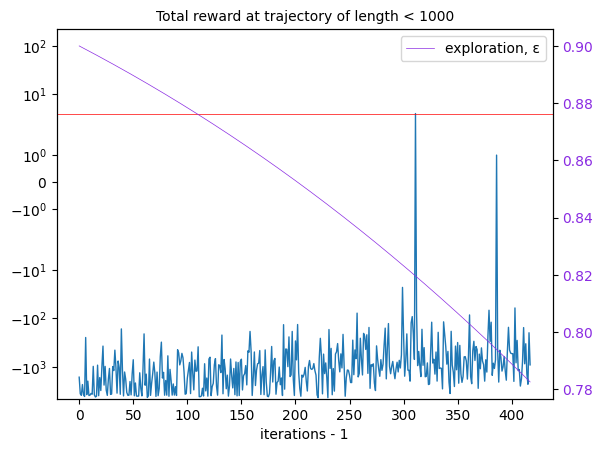

In [ ]:
mca = MonteCarloAgent()
# (mca.walk_r(0.7, 5)[0] == mca.walk_gn_test(0.7,5)[0]).any()
mca.fit(n_trajectories=2000, max_length=1000, gamma=0.9999, verbose=True)

In [1076]:
res = sarsa.walk(40)
# res = qlr.walk(40)
# res = cea.walk(40)
sum(res['r'])
# cea.capture(100)

7

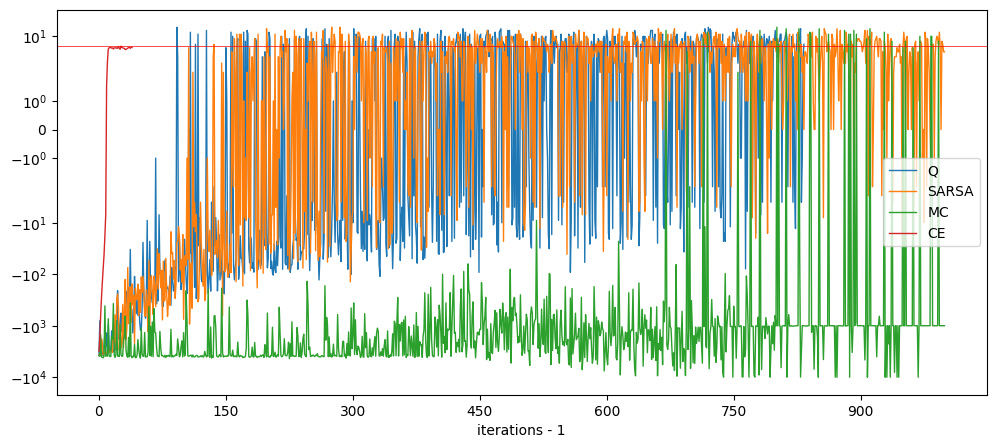

In [981]:
plt.figure(figsize=(12,5))
ax = qlr.learning_curve(logscale=True, label='Q', show_max=False)
ax = sarsa.learning_curve(logscale=True, label='SARSA', ax=ax, show_max=False)
ax = mca.learning_curve(logscale=True, label='MC', ax=ax, show_max=False)
ax = cea.learning_curve(logscale=True, label='CE', ax=ax, show_max=True)